In [1]:
import pandas as pd
import numpy as np
import pyodbc

In [2]:
connection = pyodbc.connect('DSN=TDPRD1')

In [3]:
sql = """select
    A.ord_fr_supl_id as supl_id,
	A.purch_doc_nbr,
    A.purch_doc_line_nbr ,
    A.purch_org_cd, 
    A.supl_mtrl_nbr, 
    --A.purch_doc_line_shrt_dsc,
    A.purch_line_net_usd_amt, 
    A.mtrl_grp_cd ,
    A.plnt_nm, 
    A.plnt_id, 
    A.mtrl_id,
	--A.intrnl_po_note_txt,
	A.purch_doc_cre_uid,
	A.purch_grp_cd,
	A.supplier_tender_date,
	A.stats_dlvr_dt,
	A.dlvr_dt,
	CASE WHEN A.purch_line_rcv_sts_cd IN ('OPEN','PARTIAL') THEN NULL ELSE A.purch_line_last_rcpt_dt - A.dlvr_dt END as DaysLate,
	purch_line_last_rcpt_dt,
	A.purch_line_rcv_sts_cd,
    B.itm_dsc,
	A.shp_cond_cd,
	Cast(A.purch_line_cre_ts as Date) POCreate,
	A.stats_dlvr_dt - Cast(A.purch_line_frst_authr_ts as Date) as LeadTime,
	Cast(A.purch_line_frst_authr_ts as Date) as purch_line_frst_authr_dt,
	CASE WHEN S.OpenPOCnt IS NULL THEN 0 ELSE S.OpenPOCnt END as OpenPOCnt,
	CASE WHEN S.OpenPOPrice IS NULL THEN 0 ELSE S.OpenPOPrice END as OpenPOPrice,
	to_char(A.dlvr_dt, 'Month') as MonthDue,
	'Week '||to_char(A.dlvr_dt, 'iw') as WeekDue,
	A.tchls_ind,
	CASE WHEN e.EventCnt > 0 THEN e.EventCnt ELSE 0 End as EventCnt,
	A.cfm_ctrl_cd
	
	
from Procurement_Analysis.v_fact_purch_ord_line A
left join Procurement_Analysis.v_dim_itm B
on B.itm_id=A.mtrl_id
/*
left join Factory_Materials_Analysis.v_dim_fctry_item_strg_loc F
on A.mtrl_id = F.itm_id and A.strg_loc_id = F.strg_loc_cd --and A.ord_fr_supl_id = F.curr_supl_id
*/
left join (
	select ord_fr_supl_id,count(*) as OpenPOCnt,sum(purch_line_net_usd_amt) as OpenPOPrice
	from Procurement_Analysis.v_fact_purch_ord_line
	where purch_doc_line_del_ind not in ('Y')
	and purch_line_rcv_sts_cd IN ('OPEN','PARTIAL')
	group by ord_fr_supl_id
) S
on (A.ord_fr_supl_id = S.ord_fr_supl_id)

left join (
	select
	sr.shp_ref_nbr,
	count(e.evnt_cd) as EventCnt,
	min(CAST(utc_bol_evnt_dt AS TIMESTAMP(0)) + (utc_bol_evnt_tm - TIME '00:00:00' HOUR TO SECOND)) as MinEventDate

	from shipment.v_bol_ref_TRK sr
	left join shipment.v_bol_hdr_TRK sh
	on sr.bol_id=sh.bol_id
	left join  shipment.v_bol_evnt_TRK e
	on e.bol_id = sh.bol_id
	where e.evnt_cd in ('HIC','ADQ','CAN')
	and sr.shp_ref_nbr like '7%'
	and length(sr.shp_ref_nbr)=10
	group by sr.shp_ref_nbr
) e
on e.shp_ref_nbr = A.purch_doc_nbr

where A.purch_line_frst_authr_dt >= trunc(add_months(current_date,-24), 'MM') AND Extract (YEAR From A.purch_line_frst_authr_dt) NOT IN (9999)
and A.purch_doc_nbr like '7%'
and A.strg_loc_id In ('24','26','33','107','167','189','193','194','188','210')
and A.purch_doc_line_del_ind not in ('Y')"""
data = pd.read_sql(sql,connection)

In [14]:
# identify numeric vs categorical features

data['IsLate'] = np.where(data['DaysLate'] > 0, 'Late', 'OnTime')
df_training = data[(data.DaysLate.notnull()) & (data.purch_line_rcv_sts_cd.str.strip() == 'COMPLETE')]

numeric_features = df_training.select_dtypes(include=np.number).columns#.tolist()

categorical_features = df_training.select_dtypes(include=['object']).drop(['IsLate'], axis=1).columns

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [16]:
# use the ColumnTransformer to apply the transformations to the correct columns in the dataframe

from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [17]:
data['IsLate'] = np.where(data['DaysLate'] > 0, 'Late', 'OnTime')
df_training = data[(data.DaysLate.notnull()) & (data.purch_line_rcv_sts_cd.str.strip() == 'COMPLETE')]

# data.columns
selectedFeatures = ['supl_id','purch_org_cd','supl_mtrl_nbr','plnt_id','mtrl_id','purch_doc_cre_uid','purch_grp_cd',
                    'shp_cond_cd','LeadTime','purch_line_net_usd_amt',
                    'OpenPOCnt','OpenPOPrice','WeekDue','tchls_ind','EventCnt','cfm_ctrl_cd','IsLate']

df_training = df_training[selectedFeatures]

# impute missing values with column's median value or zero
df_training['LeadTime'] = df_training['LeadTime'].fillna(df_training['LeadTime'].median())
df_training['purch_line_net_usd_amt'] = df_training['purch_line_net_usd_amt'].fillna(df_training['purch_line_net_usd_amt'].median())

# scale numeric columns
from sklearn.preprocessing import minmax_scale
df_training[['LeadTime','purch_line_net_usd_amt','OpenPOCnt','OpenPOPrice','EventCnt']] = minmax_scale(df_training[['LeadTime','purch_line_net_usd_amt','OpenPOCnt','OpenPOPrice','EventCnt']])

X = df_training.drop(['IsLate'], axis=1)
y = df_training[['IsLate']]

In [18]:
#update categoryical variables to "dummy" variables using One hot encoding
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(categories='auto',handle_unknown='ignore')
enc.fit(X)
X_one_hot = enc.transform(X)

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_one_hot, y, test_size=0.3, random_state=1)

In [45]:
# use to add records to minority class(Late) to be balanced with majority class(OnTime)
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')
X_train_upsampled, y_train_upsampled = smote.fit_sample(X_train, y_train.iloc[:,0])

In [146]:
# use to remove records from majority class(OnTime) to be balanced with minority class(Late)
#from imblearn.under_sampling import RandomUnderSampler

#rus = RandomUnderSampler(random_state=42)

#X_train_undersampled, y_train_undersampled = rus.fit_resample(X_train, y_train.iloc[:,0])

In [46]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

lr_pipeline= Pipeline([
    ('preprocessor', preprocessor),
    ('LogisticRegression', LogisticRegression(solver='lbfgs',
                                              multi_class='auto',
                                              max_iter=10000,
                                              n_jobs=-1,
                                              verbose=2,
                                              class_weight='balanced'))
])

lr_pipeline.fit(X_train, y_train.values.ravel())
lr_predictions= lr_pipeline.predict(X_test)

print(classification_report(y_test, lr_predictions))
print(confusion_matrix(y_test, lr_predictions))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   14.4s finished


              precision    recall  f1-score   support

        Late       0.43      0.70      0.53      8554
      OnTime       0.93      0.81      0.87     43180

    accuracy                           0.79     51734
   macro avg       0.68      0.76      0.70     51734
weighted avg       0.85      0.79      0.81     51734

[[ 6019  2535]
 [ 8099 35081]]


In [61]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

rf_pipeline = Pipeline([
    ('RandomForestClassifier', RandomForestClassifier(class_weight='balanced',
                                                      verbose=2,
                                                      n_estimators=100,
                                                      n_jobs=-1))
])

rf_pipeline.fit(X_train, y_train.values.ravel())
rf_predictions= rf_pipeline.predict(X_test)

print(classification_report(y_test, rf_predictions))
print(confusion_matrix(y_test, rf_predictions))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100building tree 8 of 100

building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.8min


building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  9.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.6s finished


              precision    recall  f1-score   support

        Late       0.75      0.49      0.59      8554
      OnTime       0.90      0.97      0.94     43180

    accuracy                           0.89     51734
   macro avg       0.83      0.73      0.76     51734
weighted avg       0.88      0.89      0.88     51734

[[ 4159  4395]
 [ 1362 41818]]


In [38]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import Pipeline

xtra_pipeline= Pipeline([
    ('ExtraTreesClassifier', ExtraTreesClassifier(n_estimators=100,verbose=2,n_jobs=-1))   
])

xtra_pipeline.fit(X_train_upsampled, y_train_upsampled.values.ravel())
xtra_predictions= xtra_pipeline.predict(X_test)

print(classification_report(y_test, xtra_predictions))
print(confusion_matrix(y_test, xtra_predictions))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100


KeyboardInterrupt: 

In [72]:
from sklearn.pipeline import Pipeline
import lightgbm as lgb

lgb_pipeline = Pipeline([
    ('LGBMClassifier', lgb.LGBMClassifier(verbosity=2,n_jobs=-1))   
])

lgb_pipeline.fit(X_train_upsampled, y_train_upsampled)
lgb_predictions = lgb_pipeline.predict(X_test)

print(classification_report(y_test, lgb_predictions))
print(confusion_matrix(y_test, lgb_predictions))

              precision    recall  f1-score   support

        Late       0.56      0.43      0.48      8554
      OnTime       0.89      0.93      0.91     43180

    accuracy                           0.85     51734
   macro avg       0.72      0.68      0.70     51734
weighted avg       0.84      0.85      0.84     51734

[[ 3663  4891]
 [ 2903 40277]]


In [134]:
data['IsLate'] = np.where(data['DaysLate'] > 0, 'Late', 'OnTime')
df_training = data[(data.DaysLate.notnull()) & (data.purch_line_rcv_sts_cd.str.strip() == 'COMPLETE')]

# data.columns
selectedFeatures = ['supl_id','IsLate']

df_training = df_training[selectedFeatures]

# impute missing values with column's median value or zero


# scale numeric columns
from sklearn.preprocessing import minmax_scale


X = df_training.drop(['IsLate'], axis=1)
y = df_training[['IsLate']]

In [102]:
# Total number of missing values
print (df_training.isnull().sum().sum())

0


In [9]:
# Total missing values for each feature
print (df_training.isnull().sum())

supl_id                   0
purch_org_cd              0
supl_mtrl_nbr             0
plnt_id                   0
mtrl_id                   0
purch_doc_cre_uid         0
purch_grp_cd              0
shp_cond_cd               0
LeadTime                  0
purch_line_net_usd_amt    0
OpenPOCnt                 0
OpenPOPrice               0
WeekDue                   0
tchls_ind                 0
EventCnt                  0
cfm_ctrl_cd               0
IsLate                    0
dtype: int64


In [152]:
y_train_upsampled

0         OnTime
1         OnTime
2         OnTime
3         OnTime
4         OnTime
           ...  
365809      Late
365810      Late
365811      Late
365812      Late
365813      Late
Name: IsLate, Length: 365814, dtype: object

In [20]:
from collections import Counter
print('Resampled dataset shape %s' % Counter(y))

Resampled dataset shape Counter({'IsLate': 1})


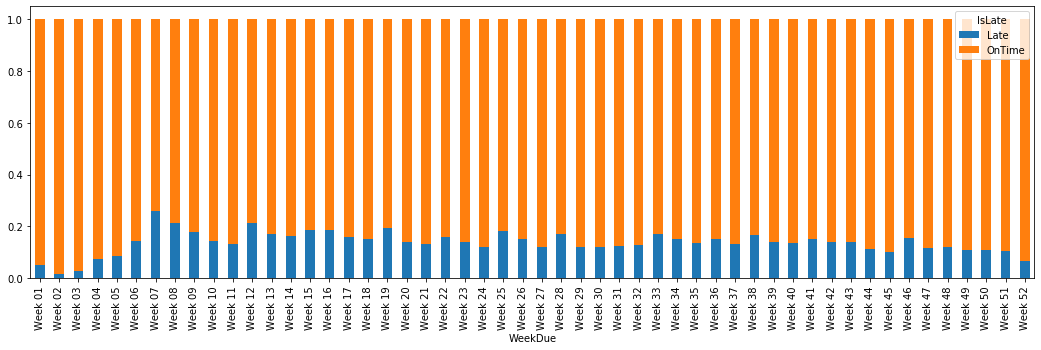

In [37]:
# Use this to compare each feature against the dependent variable, IsLate to visually determine its importance. It shows the proportion of Late to OnTime orders.

props = df_training.groupby("WeekDue")['IsLate'].value_counts(normalize=True).unstack()
props.plot(kind='bar', stacked='True', figsize=(18,5))

In [35]:
# Use this to determine strength of correlations between numeric features and the dependent variable.

corr = df_training[['EventCnt','LeadTime','purch_line_net_usd_amt','OpenPOCnt','OpenPOPrice','IsLate']]
corr['IsLate']=(corr['IsLate']=='Late').astype(int)

corr.corr()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,EventCnt,LeadTime,purch_line_net_usd_amt,OpenPOCnt,OpenPOPrice,IsLate
EventCnt,1.000000,-0.001218,0.010374,-0.011273,-0.004980,0.064063
LeadTime,-0.001218,1.000000,-0.000055,0.026927,0.023972,-0.002038
purch_line_net_usd_amt,0.010374,-0.000055,1.000000,-0.068516,-0.008734,0.094218
OpenPOCnt,-0.011273,0.026927,-0.068516,1.000000,0.554921,-0.098676
OpenPOPrice,-0.004980,0.023972,-0.008734,0.554921,1.000000,-0.012139
IsLate,0.064063,-0.002038,0.094218,-0.098676,-0.012139,1.000000


In [76]:
df_training

,supl_id,purch_org_cd,supl_mtrl_nbr,plnt_id,mtrl_id,purch_doc_cre_uid,purch_grp_cd,shp_cond_cd,LeadTime,purch_line_net_usd_amt,OpenPOCnt,OpenPOPrice,WeekDue,tchls_ind,EventCnt,cfm_ctrl_cd,IsLate
0,1000022420,1008,YEE-001484-1,CD,000000000500201857,XI_WIINGS,FOM,Y0,0.000547,0.000012,0.000000,0.000000e+00,Week 06,N,0.0,A,OnTime
1,1000100761,1005,0466-0448-03-01-4-1,PG,000000000500290807,XI_WIINGS,FLM,Y0,0.000542,0.001118,0.005806,5.555700e-07,Week 52,N,0.0,A,OnTime
2,1000015798,1127,100096180,CH,000000000500380950,XI_WIINGS,FQD,Y0,0.000552,0.000334,0.010246,9.757077e-04,Week 29,N,0.0,A,OnTime
4,1000079485,1005,ROMN- 10 X 1.5,PG,000000000500298553,XI_WIINGS,F2R,Y0,0.000550,0.000130,0.001025,7.444866e-08,Week 08,N,0.0,A,OnTime
5,1000001691,1149,1978328002,SS,000000000500130359,XI_WIINGS,FLM,Y0,0.000553,0.003797,0.506148,3.972384e-03,Week 21,N,0.0,A,OnTime
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184501,1000029193,1005,DMF-ZZZ101350-1,KMA,000000000500131311,XI_WIINGS,FOM,Y0,0.000557,0.000980,0.014344,6.945043e-06,Week 07,N,0.0,A,OnTime
184502,1000029193,1005,DMF-ZZZ101350-1,PG,000000000500131311,XI_WIINGS,FOM,Y0,0.000557,0.000980,0.014344,6.945043e-06,Week 51,N,0.0,A,OnTime
184503,1000029193,1005,DMF-ZZZ101350-1,KMA,000000000500131311,XI_WIINGS,FOM,Y0,0.000556,0.001050,0.014344,6.945043e-06,Week 10,N,0.0,A,OnTime
184504,1000012323,1005,A531834,PG,000000000500283107,XI_WIINGS,FP1,Y0,0.000557,0.006024,0.033128,3.062282e-05,Week 34,N,0.0,A,OnTime


In [67]:
df_training.to_csv(r'C:\Users\jrstrong\Desktop\temp\AT_IDM_Overdue.csv', index=False)

In [ ]:
df_training.IsLate.select_dtypes(include=np.number).columns.tolist()

In [24]:
y.count()

IsLate    172533
dtype: int64